In [1]:
from wordpress_graph.paths import DATA_DIR
import feedparser
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
xml_files = list(DATA_DIR.glob('xml/*.xml'))

In [3]:
def post_info_from_xml(
    xml_files,
    categories_to_subset=[
        "Papers",
        "Dissertations",
        "Paper reviews",
        "Blogs",
        "Datasets",
    ],
):
    post_df = pd.DataFrame(columns=["title", "tags", "category", "link", "date"])

    for xml_file in xml_files:
        # parse file
        d = feedparser.parse(xml_file)
        # unique entry types
        print(np.unique([i.wp_post_type for i in d.entries]))

        # go through entries
        for entry in tqdm(d.entries):
            # only interested in posts
            if entry.wp_post_type == "post":
                if entry.wp_status == "publish":
                    title = entry.title
                    tags = [tag.term for tag in entry.tags if tag.scheme == "post_tag"]
                    category = [
                        tag.term for tag in entry.tags if tag.scheme == "category"
                    ][0]
                    link = entry.link
                    publish_date = entry.published_parsed
                    post_df.loc[len(post_df)] = [
                        title,
                        tags,
                        category,
                        link,
                        publish_date,
                    ]

    post_df["slug"] = [i.lower().replace(" ", "_") for i in post_df.title.values]
    # subset only papers
    post_df = post_df[post_df.category.isin(categories_to_subset)]
    return post_df

In [4]:
post_df = post_info_from_xml(xml_files)

['attachment' 'nav_menu_item' 'post']



['attachment' 'post']


In [5]:
display(post_df[:3])
len(post_df)

,title,tags,category,link,date,slug
0,Critical Behavior from Deep Dynamics: A Hidden...,"[Language, LSTM, Markov]",Papers,https://timsainburg.wordpress.com/2016/08/05/c...,"(2016, 8, 5, 2, 33, 37, 4, 218, 0)",critical_behavior_from_deep_dynamics:_a_hidden...
1,Adversarially Learned Inference,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/a...,"(2016, 8, 5, 2, 58, 40, 4, 218, 0)",adversarially_learned_inference
2,InfoGAN: Interpretable Representation Learning...,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/i...,"(2016, 8, 5, 3, 1, 20, 4, 218, 0)",infogan:_interpretable_representation_learning...


437

#### tag info

In [6]:
all_tags = np.concatenate(post_df.tags.values)
len(all_tags)

1768

In [7]:
# get tag freqiemcoes
tag_df = pd.DataFrame([[i, np.sum(all_tags == i)] for i in np.unique(all_tags)], columns = ['tag', 'frequency'])

,tag,frequency
487,syntax,78
10,Birdsong,64
267,hierarchy,59
51,Language,43
52,Language Acquisition,31
445,sequence learning,27
83,Recursion,25
541,zebra finch,24
524,vocalization,23
61,Markov Models,22


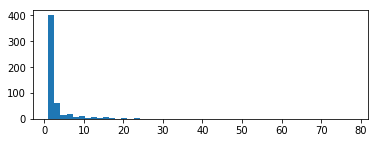

In [8]:
display(tag_df.sort_values(by="frequency", ascending=False)[:10])
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(tag_df.frequency, bins=50);

In [9]:
len(np.unique(np.concatenate(post_df.tags.values)))

543

### Make a graph
- the value of edges should be weighted by frequency of the overlapping tag

In [10]:
def post_df_to_graph(post_df, all_tags):
    """ Create a graph from post tags
    """
    # Create graph
    G=nx.Graph()
    
    # add nodes to graph
    for idx, row in post_df.iterrows():
        G.add_node(row.slug, type = row.category)

    ## add edges to graph
    # get weight as # of similar tags between two posts
    for idx, row in tqdm(post_df.iterrows(), total = len(post_df)):
        for idx2, row2 in post_df.iterrows():
            if row.title != row2.title:
                overlap = [tag for tag in row.tags if tag in row2.tags]
                if len(overlap) > 0:
                    # weight tags by frequency
                    weights = [1/np.log(tag_df[tag_df.tag == tag].frequency.values[0]) for tag in overlap]
                    weight = np.sum(weights)
                    # add edge
                    if weight > 0:
                        G.add_edge(row.slug, row2.slug, weight=weight)
    
    # remove nodes that aren't connected to anything
    num_conns = pd.DataFrame(columns=['node', 'conns'])
    # remove nodes that have no connections
    for node in list(G.nodes().keys()):
        if G.degree(node) == 0:
            G.remove_node(node)
        else:
            num_conns.loc[len(num_conns)] = [node, G.degree(node)]
    return G, num_conns

In [11]:
G, num_conns = post_df_to_graph(post_df, all_tags)
print(len(G.edges()), len(G.nodes()))


11753 420


,node,conns
345,experimental_evidence_for_compositional_syntax...,194
63,songbirds_possess_the_spontaneous_ability_to_d...,176
213,biological_foundations_and_origins_of_syntax,174
365,experimental_evidence_for_phonemic_contrasts_i...,173
104,songs_to_syntax:_the_linguistics_of_birdsong,173


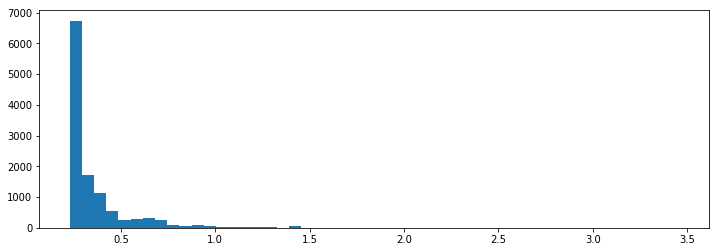

In [12]:
# show top connected posts
display(num_conns.sort_values(by="conns", ascending=False)[:5])
# take a look at the weight probabilities
weights = np.array([i['weight'] for i in list(G.edges().values())])
fig, ax = plt.subplots(ncols=1, figsize=(12,4))
ax.hist(weights, bins=50);

### Generate layouts

In [13]:
spring_pos = nx.spring_layout(G, k=1/len(G.nodes())**.25)

In [14]:
kamada_kawai_pos = nx.drawing.layout.kamada_kawai_layout(G)

### Cluster communiities

In [15]:
import community
import seaborn as sns

In [16]:
partition = community.best_partition(G)
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7}

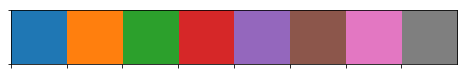

In [17]:
pal = sns.color_palette("tab10", n_colors=len(set(partition.values())))
sns.palplot(pal)

In [18]:
def set_axis_lims(ax, pos, nstd=2):
    pos_array = np.vstack(pos.values())
    pos_mean = np.mean(pos_array, axis=0)
    pos_std = np.std(pos_array, axis=0)

    ax.set_xlim([pos_mean[0] - pos_std[0] * 3, pos_mean[0] + pos_std[0] * 3])
    ax.set_ylim([pos_mean[1] - pos_std[1] * 3, pos_mean[1] + pos_std[1] * 3])

### Plot in networkx

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

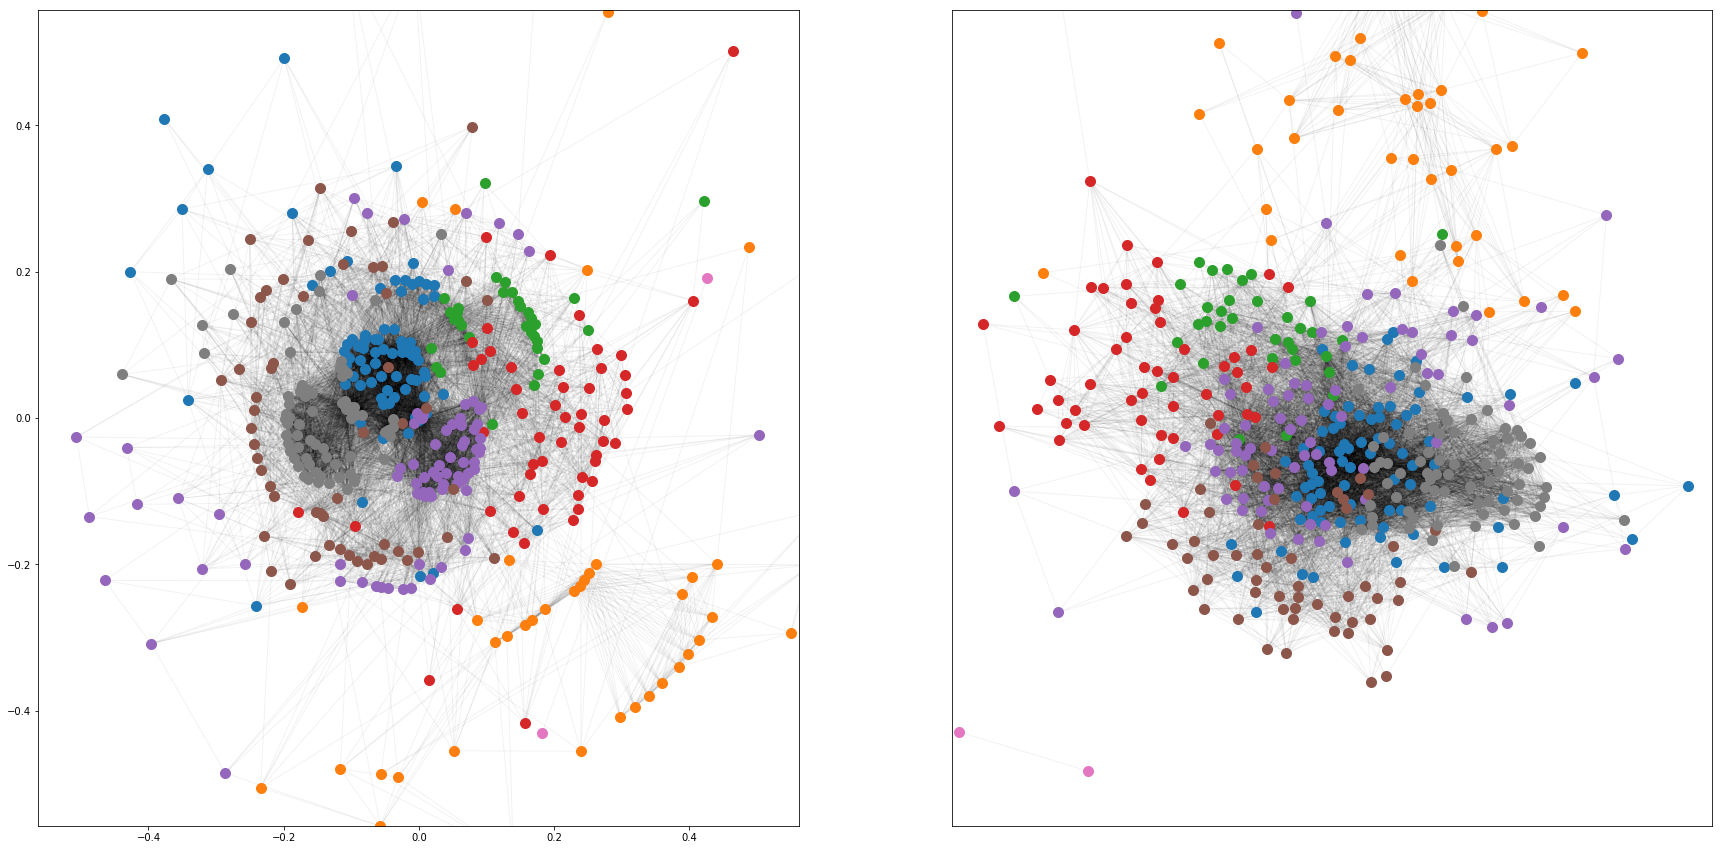

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))

for pos, ax in zip([kamada_kawai_pos, spring_pos], axs):
    for count, com in enumerate(set(partition.values())):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(
            G, pos, list_nodes, node_size=100, node_color=list(pal[count]), ax=ax
        )

    nx.draw_networkx_edges(G, pos, alpha=0.05, ax=ax)

    set_axis_lims(ax, pos, nstd=2)
